# Sample a source with energy-dependent evolution
This notebook shows how to learn sampling events of sources with an energy-dependent model.

## Prerequisites
To understand how to generate a model and a MapDataset and how to fit the data, please refer to the `~gammapy.modeling.models.SkyModel` and
:doc:`/tutorials/analysis-3d/simulate_3d` tutorial. To know how to sampling events for more standards source, we suggest to visit the event sampler :doc:`/tutorials/analysis-3d/event_sampling` tutorial.

## Objective
Describe the process of sampling events from the background plus a source having an energy-dependent temporal model, and obtain an output event-list.

## Proposed approach
Here we will show how to create an energy dependent model; then we also an observation and create a Dataset object. Finally we describe how to sample events from the model.

We will work with the following functions and classes:

-  `~gammapy.data.Observations`
-  `~gammapy.datasets.Dataset`
-  `~gammapy.modeling.models.SkyModel`
-  `~gammapy.datasets.MapDatasetEventSampler`
-  `~gammapy.data.EventList`


## Setup
As usual, let’s start with some general imports…

In [110]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from regions import PointSkyRegion
from gammapy.data import GTI, DataStore, Observation, observatory_locations
from gammapy.data.pointing import FixedPointingInfo, PointingMode
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.datasets.tests.test_map import get_map_dataset
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis, RegionNDMap, WcsGeom, Map
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ConstantSpectralModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    LightCurveTemplateTemporalModel,
    Models,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.utils.testing import requires_data

## Check setup

In [111]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()


System:

	python_executable      : /Users/fabiopintore/opt/anaconda3/envs/gammapy-dev/bin/python 
	python_version         : 3.8.13     
	machine                : x86_64     
	system                 : Darwin     


Gammapy package:

	version                : 0.20.2.dev126+g59f6c1155.d20220907 
	path                   : /Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy 


Other packages:

	numpy                  : 1.22.4     
	scipy                  : 1.9.1      
	astropy                : 5.1        
	regions                : 0.6        
	click                  : 8.1.3      
	yaml                   : 6.0        
	IPython                : 8.5.0      
	jupyterlab             : 3.4.6      
	matplotlib             : 3.5.3      
	pandas                 : 1.4.4      
	healpy                 : 1.16.1     
	iminuit                : 2.12.2     
	sherpa                 : 4.14.1     
	naima                  : 0.10.0     
	emcee                  : 3.1.2      
	corner                 : 2.2.1      


## Create the energy-dependent model
The source we want to simulate is one where its spectrum vary as a function of the time.
We define this source with a point-like spatial morphology: we note that this is a mandatory condition to use the Gammapy event sampler, which is not yet available for extended morphology. 
Since the source spectrum is variable with time, the current format to handle the temporal and energy information is to store it into a `~gammapy.Map.RegionNDMap`. The model will vary in 5 time bins, and in each bin the source spectrum is a powerlaw with the amplitude and index shown in this box. The spectral evolution is also shown in the following plot:

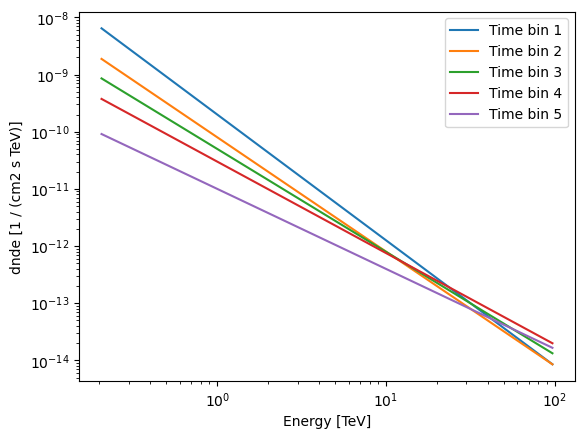

In [112]:
ampl_model = np.array([2e-10, 8e-11, 5e-11, 3e-11, 1e-11]) * u.cm**-2 * u.TeV**-1 * u.s**-1 # amplitude
index_model = np.array([2.2, 2.0, 1.8, 1.6, 1.4]) # index

for i in np.arange(len(ampl_model)):
    spec = PowerLawSpectralModel(index=index_model[i], 
                                amplitude=ampl_model[i], 
                                reference="1 TeV")
    spec.plot([0.2,100]*u.TeV, label=f"Time bin {i+1}")
plt.legend()

Let's now create the temporal model that will be defined as a `LightCurveTemplateTemporalModel`. The latter can take in input a `RegionNDMap` where the time and energy source information are stored. To create the map, we firstly need to define the time axis with `MapAxis`: here we consider 5 time bins of 720 s (i.e. 1 hr in total). We warn the reader to carefully check the interpolation method used for the time axis, as different methods provide different results. 
As a second step, we create an energy axis with 10 bins where the powerlaw spectral models will be evaluated. 

In [113]:
# source position
position = SkyCoord("100 deg", "30 deg", frame="icrs")

# time axis
time_bins = 720
time_min = np.arange(0, 3600, time_bins) * u.s
time_max = np.arange(720, 4320, time_bins) * u.s
edges = np.append(time_min, time_max[-1])
time_axis = MapAxis.from_edges(edges=edges, name="time", interp="lin")

# energy axis
nbin = 10
energy_axis = MapAxis.from_energy_bounds(
    energy_min=0.2 * u.TeV, energy_max=100 * u.TeV, 
    nbin=nbin, name="energy"
)

Now let's create the `RegionNDMap` and fill it with the expect spectral values:

In [114]:
# make an array with the time and energy shape
data = (np.ones((len(time_min), energy_axis.nbin )) 
        * u.cm**-2 * u.s**-1 * u.TeV**-1)

# create the RegionNDMap
m = RegionNDMap.create(
    region=PointSkyRegion(center=position),
    axes=[energy_axis, time_axis],
)

# evaluate the spectrum and fill the RegionNDMap
for i in np.arange(len(time_min)):
    spec = PowerLawSpectralModel(index=index_model[i], 
                                 amplitude=ampl_model[i], 
                                 reference="1 TeV")
    data[i, :], _ = spec.evaluate_error(energy_axis.center)

m.data = np.array(data)

Now, we define `LightCurveTemplateTemporalModel` passing it the map we created before. We note that an interpolation scheme is also provided when loading an map: for a an energy-dependent temporal model, the `method` and `values_scale` arguments by default are set to `linear` and `log`. Users can modify them but we warn that this should be done only when the users knows the consequences of the changes. Here, we show how to set them explicitely.

Furthermore, we create the complete `SkyModel` of the source plus the background model. Note that the `spectral_model` represents a constant spectrum: this is mandatory, as the real source spectrum is passed through the map. 

In [115]:
t_ref = Time(51544.00074287037, format="mjd", scale="tt")
temporal_model = LightCurveTemplateTemporalModel(m, t_ref=t_ref, method="linear", values_scale="log")

spatial_model = PointSpatialModel.from_position(position)
spectral_model = ConstantSpectralModel(const="1 cm-2 s-1 TeV-1")

model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    temporal_model=temporal_model,
    name="test-source",
)

bkg_model = FoVBackgroundModel(dataset_name="my-dataset")    

models = [model, bkg_model]

(<AxesSubplot:xlabel='Time [iso]', ylabel='Norm / A.U.'>,
 RegionNDMap
 
 	geom  : RegionGeom 
  	axes  : ['lon', 'lat', 'time', 'energy']
 	shape : (1, 1, 100, 1)
 	ndim  : 4
 	unit  : 
 	dtype : float64)

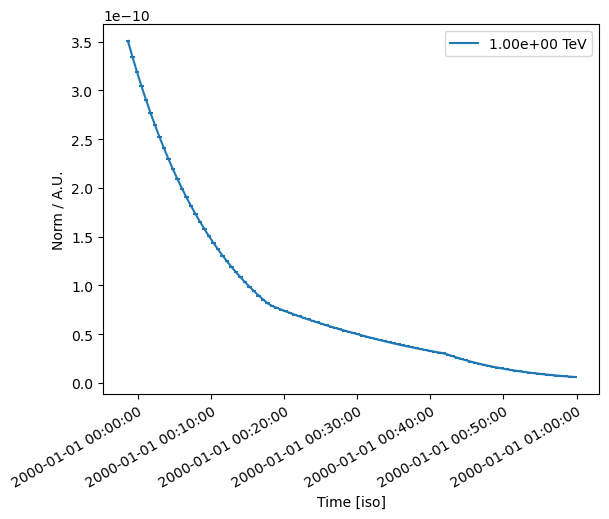

In [116]:
# a visual inspection of the temporal model at 1 TeV
t = temporal_model.reference_time + np.linspace(-100,3600,10000) * u.s
t = Time(t, format="mjd")
f = temporal_model.evaluate(t, energy=1*u.TeV)
temporal_model.plot(time_range=(t[0],t[-1]), energy=[1]*u.TeV)

## Define an observation and make a dataset
In the following, we define an observation of 1 hr with CTA in the alpha-configuration for the south array, and we also create a dataset to be passed to the event sampler. We pass the `SkyModel` we create above to the dataset. 

In [117]:
path = Path("$GAMMAPY_DATA/cta-caldb")
irf_filename = "Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz"

pointing = SkyCoord(100.0, 30.0, frame="icrs", unit="deg")
livetime = 1 * u.hr

In [118]:
irfs = load_irf_dict_from_file(path / irf_filename)
location = observatory_locations["cta_south"]

observation = Observation.create(
    obs_id=1001,
    pointing=pointing,
    livetime=livetime,
    irfs=irfs,
    location=location,
)

/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


In [119]:
energy_axis = MapAxis.from_energy_bounds("0.2 TeV", "100 TeV", nbin=5, per_decade=True)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.05 TeV", "150 TeV", nbin=10, per_decade=True, name="energy_true"
)
migra_axis = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

geom = WcsGeom.create(
    skydir=pointing,
    width=(2, 2),
    binsz=0.02,
    frame="icrs",
    axes=[energy_axis],
)

In [120]:
empty = MapDataset.create(
    geom,
    energy_axis_true=energy_axis_true,
    migra_axis=migra_axis,
    name="my-dataset",
)
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
dataset = maker.run(empty, observation)

dataset.models = models

In [121]:
# #quick check to determine how many counts we expect with the spectral models...
# dataset.models[0].spectral_model= PowerLawSpectralModel(index=index[4], 
#                                 amplitude=ampl[4], 
#                                 reference="1 TeV")
# dataset.models[0].temporal_model = None
# print(dataset)

In [123]:
print(dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : test-source
  Datasets names            : None
  Spectral model type       : ConstantSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : LightCurveTemplateTemporalModel
  Parameters:
    const                         :      1.000   +/-    0.00 1 / (cm2 s TeV)
    lon_0                         :    100.000   +/-    0.00 deg         
    lat_0                         :     30.000   +/-    0.00 deg         
    t_ref                 (frozen):  51544.000       d           

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




## Let's start the simulation
Initialize and run the `MapDatasetEventSampler` class. We also define the `oversample_energy_factor`  arguments: this should be carefully considered by the user, who should understand the implications of the argument choices. Here we adopt an `oversample_energy_factor` of 10:

In [18]:
sampler = MapDatasetEventSampler(random_state=0, oversample_energy_factor=10)
events = sampler.run(dataset, observation)

In [19]:
# the number of simulated source events
idx = np.where(events.table["MC_ID"]==1)
len(idx[0])

7825

Let's inspect the simulated events in the source region:

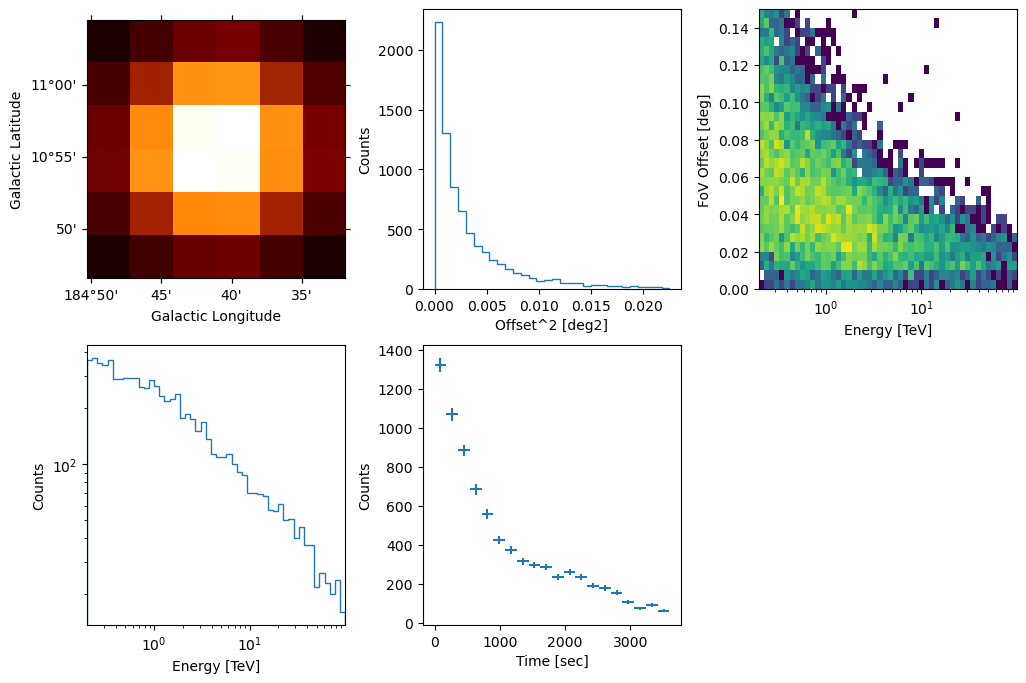

In [20]:
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion
src_position = SkyCoord(100.0, 30., frame="icrs", unit="deg")

on_region_radius = Angle("0.15 deg")
on_region = CircleSkyRegion(center=src_position, radius=on_region_radius)

src_events = events.select_region(on_region)

src_events.peek()

## Fit the simulated data

We fit the events in one time bin, adopting a model with a powerlaw spectral shape, no temporal information and a point-like morphology. We fix the source coordinates for simplicity:

In [21]:
spec = PowerLawSpectralModel(index=2, 
                             amplitude=5e-11 * u.cm**-2 * u.s**-1 * u.TeV**-1, 
                             reference="1 TeV")

spatial_model = PointSpatialModel(
    lon_0="100 deg", lat_0="30 deg", frame="icrs"
)

model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spec,
    name="fit_source",
)

model.spatial_model.parameters[0].frozen=True
model.spatial_model.parameters[1].frozen=True

bkg_model = FoVBackgroundModel(dataset_name="my-dataset")    

model_fit = [model, bkg_model]

Let's create a new observation, with the time bin starting at 360s and with a duration of 100s, and a new dataset for the fit:

In [22]:
livetime = 100 * u.s

i=0
tstart = t_ref + (time_min[i] + 360 * u.s).to("d")
observation = Observation.create(
    obs_id=1001,
    pointing=pointing,
    livetime=livetime,
    irfs=irfs,
    location=location,
    tstart = tstart
)

dataset_fit = maker.run(empty, observation)

/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We select only the events in the time bin of reference, and we fill the dataset with them. 

In [23]:
filt_evt = events.select_time([observation.gti.time_start, observation.gti.time_stop])
counts = Map.from_geom(geom)
counts.fill_events(filt_evt)
dataset_fit.counts = counts

dataset_fit.models = model_fit
print(dataset_fit.models)

DatasetModels

Component 0: SkyModel

  Name                      : fit_source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   5.00e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):    100.000       deg         
    lat_0                 (frozen):     30.000       deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV  

Let's fit the dataset

In [24]:
fit = Fit()
result = fit.run(dataset_fit)
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 96
	total stat : 2903.71

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [25]:
print(ampl_model[i], index_model[i])
result.parameters.to_table()

2e-10 1 / (cm2 s TeV) 2.2


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,2.1588e+00,,3.676e-02,nan,nan,False,False,
spectral,amplitude,1.8619e-10,cm-2 s-1 TeV-1,8.356e-12,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spatial,lon_0,1.0000e+02,deg,0.000e+00,nan,nan,True,False,
spatial,lat_0,3.0000e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,
spectral,norm,1.0407e+00,,9.698e-02,nan,nan,False,True,
spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


# A realistic case: a gravitational wave event
Here we simulate a gravitational wave event in a short CTA observation. We use a map in the ~gammapy.data repository:

In [310]:
filename = "$GAMMAPY_DATA/gravitational_waves/GW_example_DC_map_file.fits_2.fits.gz"
temporal_model_gw = LightCurveTemplateTemporalModel.read(filename, format="map")

#t_ref = Time(51544.00074287037, format="mjd", scale="tt")
#temporal_model_gw.t_ref.value = t_ref.value

#temporal_model = LightCurveTemplateTemporalModel(m, t_ref=t_ref, method="linear", values_scale="log")

In [311]:
temporal_model_gw.reference_time

<Time object: scale='utc' format='mjd' value=55555.49923398148>

In [312]:
#temporal_model_gw.reference_time = Time(temporal_model_gw.reference_time.value, format="mjd", scale="tt")

In [313]:
livetime_gw = 1000 * u.s
tstart_gw = Time(temporal_model_gw.reference_time.mjd, format="mjd", scale="utc") + (2 * u.s).to("d")
new_observation = Observation.create(
    obs_id=1001,
    pointing=temporal_model.map.geom.center_skydir,
    livetime=livetime_gw,
    irfs=irfs,
    location=location,
    tstart = tstart_gw,
    reference_time=temporal_model_gw.reference_time
)

/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


In [314]:
spatial_model_gw = PointSpatialModel.from_position(position)
spectral_model_gw = ConstantSpectralModel(const="1 cm-2 s-1 TeV-1")

model_gw = SkyModel(
    spatial_model=spatial_model_gw,
    spectral_model=spectral_model_gw,
    temporal_model=temporal_model_gw,
    name="gw",
)

bkg_model = FoVBackgroundModel(dataset_name="my-dataset")    

models_gw = [model_gw, bkg_model]

In [315]:
energy_axis_gw = MapAxis.from_energy_bounds("0.012 TeV", "100 TeV", nbin=5, per_decade=True)
energy_axis_true_gw = MapAxis.from_energy_bounds(
    "0.001 TeV", "150 TeV", nbin=10, per_decade=True, name="energy_true"
)
migra_axis = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

geom_gw = WcsGeom.create(
    skydir=temporal_model.map.geom.center_skydir,
    width=(2, 2),
    binsz=0.02,
    frame="icrs",
    axes=[energy_axis],
)

empty_gw = MapDataset.create(
    geom_gw,
    energy_axis_true=energy_axis_true_gw,
    migra_axis=migra_axis,
    name="my-dataset",
)
maker_gw = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
dataset_gw = maker_gw.run(empty_gw, new_observation)

In [316]:
dataset_gw.models = models_gw

#print(dataset_gw)
print(dataset_gw.models)

DatasetModels

Component 0: SkyModel

  Name                      : gw
  Datasets names            : None
  Spectral model type       : ConstantSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : LightCurveTemplateTemporalModel
  Parameters:
    const                         :      1.000   +/-    0.00 1 / (cm2 s TeV)
    lon_0                         :    100.000   +/-    0.00 deg         
    lat_0                         :     30.000   +/-    0.00 deg         
    t_ref                 (frozen):  55555.499       d           

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




(<AxesSubplot:xlabel='Time [iso]', ylabel='Norm / A.U.'>,
 RegionNDMap
 
 	geom  : RegionGeom 
  	axes  : ['lon', 'lat', 'time', 'energy']
 	shape : (1, 1, 100, 1)
 	ndim  : 4
 	unit  : 
 	dtype : float64)

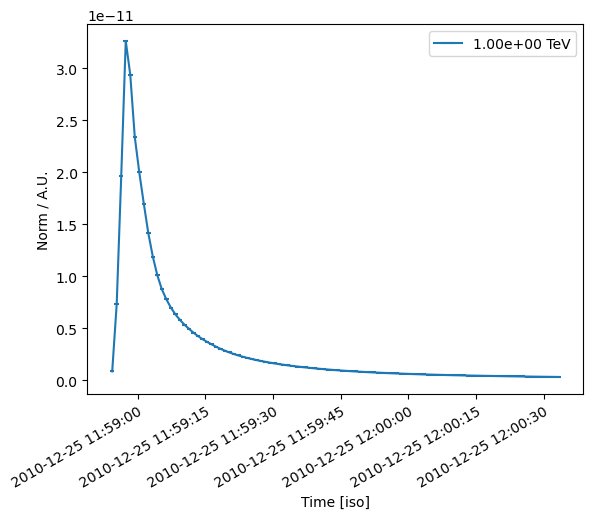

In [319]:
# a visual inspection of the temporal model at 1 TeV
t = temporal_model_gw.reference_time + np.linspace(0,100,10000) * u.s
t = Time(t, format="mjd")
f = temporal_model_gw.evaluate(t, energy=1*u.TeV)
temporal_model_gw.plot(time_range=(t[0],t[-1]), energy=[1]*u.TeV)

(<AxesSubplot:xlabel='Time [iso]', ylabel='Norm / A.U.'>,
 RegionNDMap
 
 	geom  : RegionGeom 
  	axes  : ['lon', 'lat', 'time', 'energy']
 	shape : (1, 1, 100, 1)
 	ndim  : 4
 	unit  : 
 	dtype : float64)

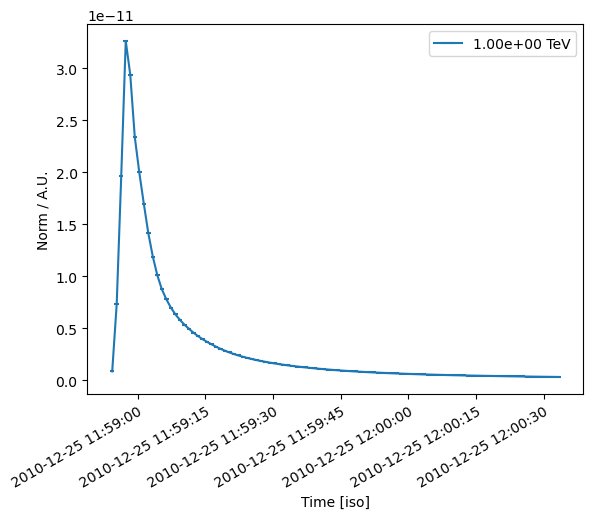

In [320]:
f = dataset_gw.models[0].temporal_model.evaluate(t, energy=1*u.TeV)
dataset_gw.models[0].temporal_model.plot(time_range=(t[0],t[-1]), energy=[1]*u.TeV)

In [321]:
sampler = MapDatasetEventSampler(random_state=0, oversample_energy_factor=10)
events_gw = sampler.run(dataset_gw, new_observation)

Position <SkyCoord (ICRS): (ra, dec) in deg
    (100., 30.)> is outside valid IRF map range, using nearest IRF defined within


In [322]:
len(events.table["MC_ID"][events.table["MC_ID"]>0])

0

###################################

###################################

###################################
# Validation code

## Perform a number of sims
###################################

###################################

###################################

In [26]:
def make_model_fit():
    spec = PowerLawSpectralModel(index=2, 
                                 amplitude=5e-11 * u.cm**-2 * u.s**-1 * u.TeV**-1, 
                                 reference="1 TeV")

    spatial_model = PointSpatialModel(
        lon_0="100 deg", lat_0="30 deg", frame="icrs"
    )

    model = SkyModel(
        spatial_model=spatial_model,
        spectral_model=spec,
        name="fit_source",
    )

    model.spatial_model.parameters[0].frozen=True
    model.spatial_model.parameters[1].frozen=True

    bkg_model = FoVBackgroundModel(dataset_name="my-dataset")    

    model_fit = [model, bkg_model]
    
    return model_fit

In [27]:
def make_dataset_fit(i, empty, events, model_fit):
    livetime = 100 * u.s

    tref = Time(51544.00074287037, format="mjd", scale="tt")
    tstart = tref + (time_min[i] + 360 * u.s).to("d")
    observation = Observation.create(
        obs_id=1001,
        pointing=pointing,
        livetime=livetime,
        irfs=irfs,
        location=location,
        tstart = tstart
    )

    dataset = maker.run(empty, observation)
    filt_evt = events.select_time([tstart, tstart + livetime])

    counts = Map.from_geom(geom)
    counts.fill_events(filt_evt)
    dataset.counts = counts
    dataset.models = model_fit

    return dataset

In [92]:
def make_diagnostic_plots(ampl_model, index_model, amplitude, amplitude_err, index, index_err, 
                          norm_bkg=None, norm_bkg_err=None):
    ampl_pull = (amplitude - ampl_model[None,:].value) / amplitude_err
    index_pull = (index - index_model[None,:]) / index_err
    amp_abs = (amplitude - ampl_model[None,:].value)
    indx_abs = (index - index_model[None,:])
    if norm_bkg is not None and norm_bkg_err is not None:
        norm_bkg_pull = (norm_bkg - 1) / norm_bkg_err

    colors = "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray"
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    for i in np.arange(len(time_min)):
        a = axs[0,0].hist(amp_abs[:,i], bins=20, label=f"timebin1, Sim. ampl.={ampl_model[i]}", 
                      histtype=u'step', color=colors[i]),
        axs[0,0].axvline(x = np.mean(amp_abs[:,i]), ymax = np.max(a[0][0]), color=colors[i]),

    axs[0,0].legend(prop={'size': 8})
    axs[0,0].set_title("Amplitude (absolute variation)")
    #axs.show()
    #plt.close()
    
    for i in np.arange(len(time_min)):
        a = axs[0,1].hist(ampl_pull[:,i], bins=20, label=f"timebin1, Sim. ampl.={ampl_model[i]}", 
                      histtype=u'step', color=colors[i]),
        axs[0,1].axvline(x = np.mean(ampl_pull[:,i]), ymax = np.max(a[0][0]), color=colors[i]),

    axs[0,1].legend(prop={'size': 8})
    axs[0,1].set_title("Amplitude (pull distribution)")
    #axs.show()
    #plt.close()

    for i in np.arange(len(time_min)):
        a = axs[1,0].hist(indx_abs[:,i], bins=20, label=f"timebin1, Sim. ampl.={index_model[i]}", 
                      histtype=u'step', color=colors[i]),
        axs[1,0].axvline(x = np.mean(indx_abs[:,i]), ymax = np.max(a[0][0]), color=colors[i]),

    axs[1,0].legend(prop={'size': 8})
    axs[1,0].set_title("Index (absolute variation)")
    #axs.show()
    #plt.close()
    
    for i in np.arange(len(time_min)):
        a = axs[1,1].hist(index_pull[:,i], bins=20, label=f"timebin1, Sim. ampl.={index_model[i]}", 
                      histtype=u'step', color=colors[i]),
        axs[1,1].axvline(x = np.mean(index_pull[:,i]), ymax = np.max(a[0][0]), color=colors[i]),

    axs[1,1].legend(prop={'size': 8})
    axs[1,1].set_title("Index (pull distribution)")
    #axs.show()
    #plt.close()

    if norm_bkg is not None:
        for i in np.arange(len(time_min)):
            plt.hist(norm_bkg_pull[:,i],bins=20, label=f"timebin1, Sim. norm.=1", 
                     histtype="step")

        plt.legend()
        plt.title("BKG Norm (pull distribution)")
        plt.show()
        plt.close()

### Start the sims

Here I assume a "nearest" interpolation method for the `LightCurveTemplateTemporalModel`:

In [107]:
Nsim = 100
method = "nearest"

temporal_model = LightCurveTemplateTemporalModel(m, t_ref=t_ref, method=method)
dataset.models[0].temporal_model = temporal_model

amplitude = np.zeros((Nsim, len(time_min)))
amplitude_err = np.zeros((Nsim, len(time_min)))
index = np.zeros((Nsim, len(time_min)))
index_err = np.zeros((Nsim, len(time_min)))
norm_bkg = np.zeros((Nsim, len(time_min)))
norm_bkg_err = np.zeros((Nsim, len(time_min)))

for i in np.arange(Nsim):
    print(f"We are performing the simulation N#. {i}")
    sampler = MapDatasetEventSampler(random_state=i)
    events = sampler.run(dataset, observation)
    
    for j in np.arange(len(time_min)):
        print(f"We are fitting the time bin N#. {j}")
        model_fit = make_model_fit()
        dataset_fit = make_dataset_fit(j, empty, events, model_fit)
        fit = Fit()
        result = fit.run(dataset_fit)
        
        amplitude[i, j] = dataset_fit.models[0].spectral_model.parameters["amplitude"].value
        amplitude_err[i, j] = dataset_fit.models[0].spectral_model.parameters["amplitude"].error
        
        index[i, j] = dataset_fit.models[0].spectral_model.parameters["index"].value
        index_err[i, j] = dataset_fit.models[0].spectral_model.parameters["index"].error
        
        norm_bkg[i, j] = dataset_fit.models[1].spectral_model.parameters["norm"].value
        norm_bkg_err[i, j] = dataset_fit.models[1].spectral_model.parameters["norm"].error

We are performing the simulation N#. 0
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 1
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 2
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 3
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 4
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 5
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 6
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 7
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 8
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 9
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 10
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 11
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 12
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 13
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 14
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 15
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 16
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 17
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 18
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 19
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 20
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 21
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 22
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 23
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 24
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 25
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 26
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 27
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 28
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 29
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 30
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 31
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 32
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 33
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 34
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 35
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 36
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 37
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 38
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 39
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 40
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 41
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 42
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 43
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 44
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 45
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 46
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 47
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 48
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 49
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 50
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 51
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 52
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 53
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 54
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 55
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 56
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 57
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 58
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 59
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 60
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 61
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 62
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 63
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 64
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 65
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 66
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 67
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 68
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 69
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 70
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 71
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 72
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 73
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 74
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 75
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 76
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 77
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 78
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 79
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 80
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 81
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 82
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 83
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 84
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 85
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 86
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 87
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 88
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 89
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 90
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 91
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 92
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 93
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 94
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 95
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 96
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 97
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 98
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 99
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


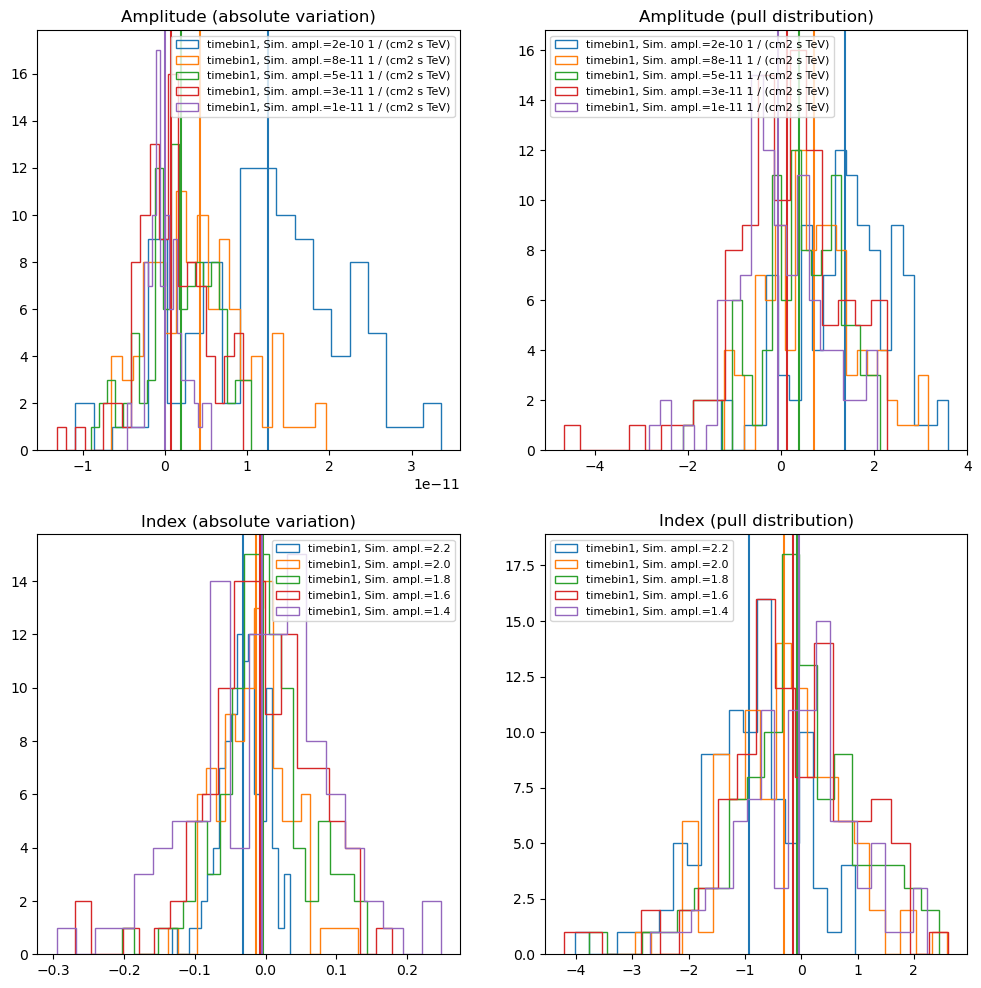

In [108]:
(amplitude_lin_near, amplitude_lin_near_err, index_lin_near, index_lin_near_err, norm_lin_near_bkg, norm_lin_near_bkg_err) = (amplitude, 
                                                                                                                              amplitude_err, index, 
                                                                                                                              index_err, 
                                                                                                                              norm_bkg, norm_bkg_err)
make_diagnostic_plots(ampl_model, index_model, amplitude_lin_near, amplitude_lin_near_err, index_lin_near, index_lin_near_err)

### Start the sims

Here I assume a "linear" interpolation method:

In [96]:
Nsim = 100
method = "linear"

temporal_model = LightCurveTemplateTemporalModel(m, t_ref=t_ref, method=method)
dataset.models[0].temporal_model = temporal_model

amplitude = np.zeros((Nsim, len(time_min)))
amplitude_err = np.zeros((Nsim, len(time_min)))
index = np.zeros((Nsim, len(time_min)))
index_err = np.zeros((Nsim, len(time_min)))
norm_bkg = np.zeros((Nsim, len(time_min)))
norm_bkg_err = np.zeros((Nsim, len(time_min)))

for i in np.arange(Nsim):
    print(f"We are performing the simulation N#. {i}")
    sampler = MapDatasetEventSampler(random_state=i)
    events = sampler.run(dataset, observation)
    
    for j in np.arange(len(time_min)):
        print(f"We are fitting the time bin N#. {j}")
        model_fit = make_model_fit()
        dataset_fit = make_dataset_fit(j, empty, events, model_fit)
        fit = Fit()
        result = fit.run(dataset_fit)
        
        amplitude[i, j] = dataset_fit.models[0].spectral_model.parameters["amplitude"].value
        amplitude_err[i, j] = dataset_fit.models[0].spectral_model.parameters["amplitude"].error
        
        index[i, j] = dataset_fit.models[0].spectral_model.parameters["index"].value
        index_err[i, j] = dataset_fit.models[0].spectral_model.parameters["index"].error
        
        norm_bkg[i, j] = dataset_fit.models[1].spectral_model.parameters["norm"].value
        norm_bkg_err[i, j] = dataset_fit.models[1].spectral_model.parameters["norm"].error

We are performing the simulation N#. 0
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 1
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 2
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 3
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 4
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 5
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 6
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 7
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 8
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 9
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 10
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 11
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 12
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 13
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 14
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 15
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 16
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 17
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 18
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 19
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 20
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 21
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 22
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 23
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 24
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 25
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 26
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 27
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 28
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 29
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 30
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 31
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 32
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 33
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 34
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 35
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 36
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 37
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 38
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 39
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 40
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 41
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 42
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 43
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 44
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 45
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 46
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 47
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 48
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 49
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 50
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 51
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 52
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 53
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 54
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 55
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 56
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 57
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 58
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 59
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 60
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 61
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 62
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 63
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 64
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 65
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 66
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 67
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 68
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 69
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 70
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 71
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 72
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 73
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 74
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 75
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 76
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 77
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 78
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 79
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 80
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 81
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 82
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 83
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 84
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 85
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 86
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 87
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 88
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 89
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 90
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 91
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 92
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 93
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 94
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 95
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 96
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 97
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 98
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 99
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


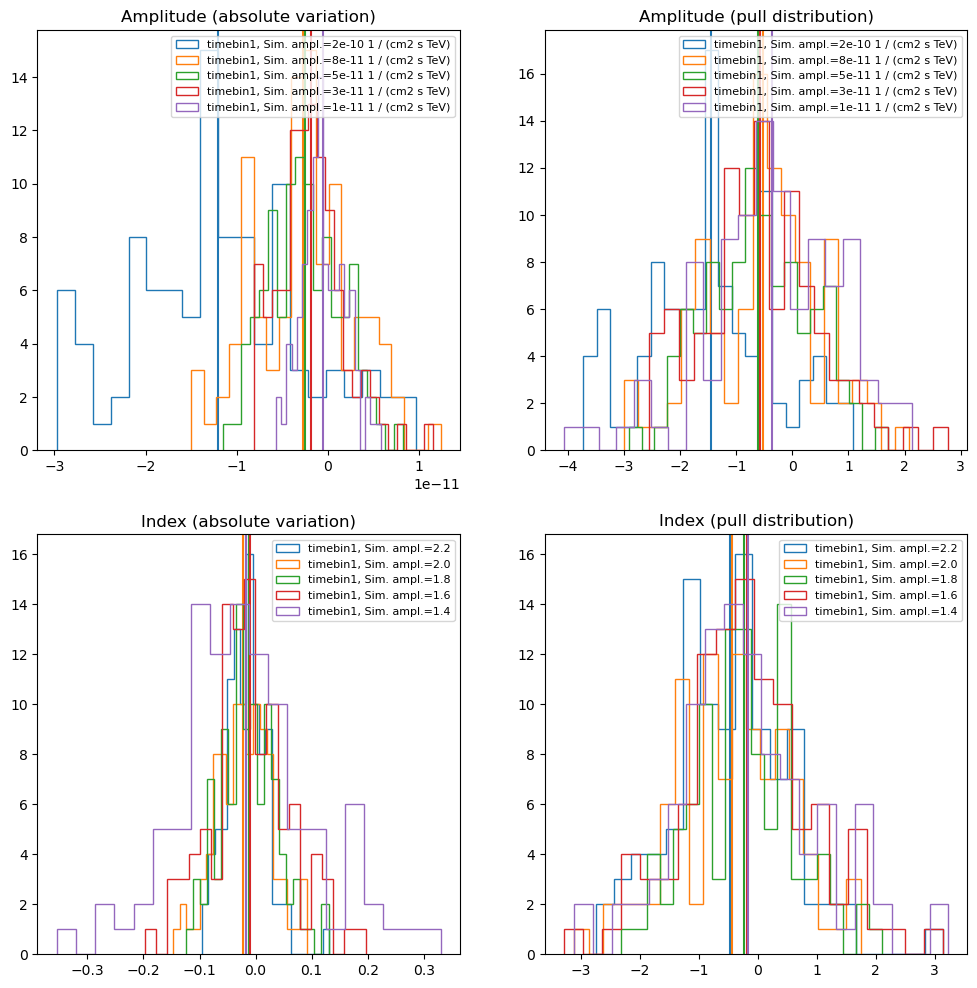

In [97]:
(amplitude_lin_lin, amplitude_lin_lin_err, index_lin_lin, index_lin_lin_err, norm_lin_lin_bkg, norm_lin_lin_bkg_err) = (amplitude, 
                                                                                                                              amplitude_err, index, 
                                                                                                                              index_err, 
                                                                                                                              norm_bkg, norm_bkg_err)
make_diagnostic_plots(ampl_model, index_model, amplitude_lin_lin, amplitude_lin_lin_err, index_lin_lin, index_lin_lin_err)

### Start the sims

Here I assume a "nearest" interpolation method and "log" for the MapAxis of the RegionNDMap:

In [ ]:
Nsim = 100
method = "nearest"

amplitude = np.zeros((Nsim, len(time_min)))
amplitude_err = np.zeros((Nsim, len(time_min)))
index = np.zeros((Nsim, len(time_min)))
index_err = np.zeros((Nsim, len(time_min)))
norm_bkg = np.zeros((Nsim, len(time_min)))
norm_bkg_err = np.zeros((Nsim, len(time_min)))


new_time_axis = MapAxis.from_edges(edges=edges, name="time", interp="log")
nbin = 10
energy_axis_map = MapAxis.from_energy_bounds(
    energy_min=0.2 * u.TeV, energy_max=100 * u.TeV, 
    nbin=nbin, name="energy"
)
m = RegionNDMap.create(
    region=PointSkyRegion(center=position),
    axes=[energy_axis_map, new_time_axis],
)

m.data = np.array(data)
new_temporal_model = LightCurveTemplateTemporalModel(m, t_ref=t_ref, method=method)
dataset.models[0].temporal_model = new_temporal_model

for i in np.arange(Nsim):
    print(f"We are performing the simulation N#. {i}")
    sampler = MapDatasetEventSampler(random_state=i)
    events = sampler.run(dataset, observation)
    
    for j in np.arange(len(time_min)):
        print(f"We are fitting the time bin N#. {j}")
        model_fit = make_model_fit()
        dataset_fit = make_dataset_fit(j, empty, events, model_fit)
        fit = Fit()
        result = fit.run(dataset_fit)
        
        amplitude[i, j] = dataset_fit.models[0].spectral_model.parameters["amplitude"].value
        amplitude_err[i, j] = dataset_fit.models[0].spectral_model.parameters["amplitude"].error
        
        index[i, j] = dataset_fit.models[0].spectral_model.parameters["index"].value
        index_err[i, j] = dataset_fit.models[0].spectral_model.parameters["index"].error
        
        norm_bkg[i, j] = dataset_fit.models[1].spectral_model.parameters["norm"].value
        norm_bkg_err[i, j] = dataset_fit.models[1].spectral_model.parameters["norm"].error

We are performing the simulation N#. 0
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 1
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 2
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 3
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 4
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 5
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 6
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 7
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 8
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 9
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 10
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 11
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 12
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 13
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 14
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 15
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 16
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 17
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 18
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 19
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 20
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 21
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 22
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 23
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 24
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 25
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 26
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 27
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 28
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 29
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 30
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 31
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 32
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 33
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 34
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 35
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 36
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 37
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 38
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 39
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 40
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 41
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 42
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 43
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 44
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 45
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 46
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 47
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 48
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 49
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 50
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 51
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 52
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 53
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 54
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 55
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 56
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 57
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 58
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 59
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 60
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 61
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 62
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 63
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 64
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 65
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 66
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 67
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 68
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 69
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 70
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 71
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 72
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 73
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 74
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 75
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 76
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 77
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 78
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 79
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 80
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 81
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 82
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 83
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 84
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 85
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 86
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 87
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 88
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 89
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 90
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 91
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 92
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 93
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 94
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 95
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 96
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 97
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 98
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 99
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


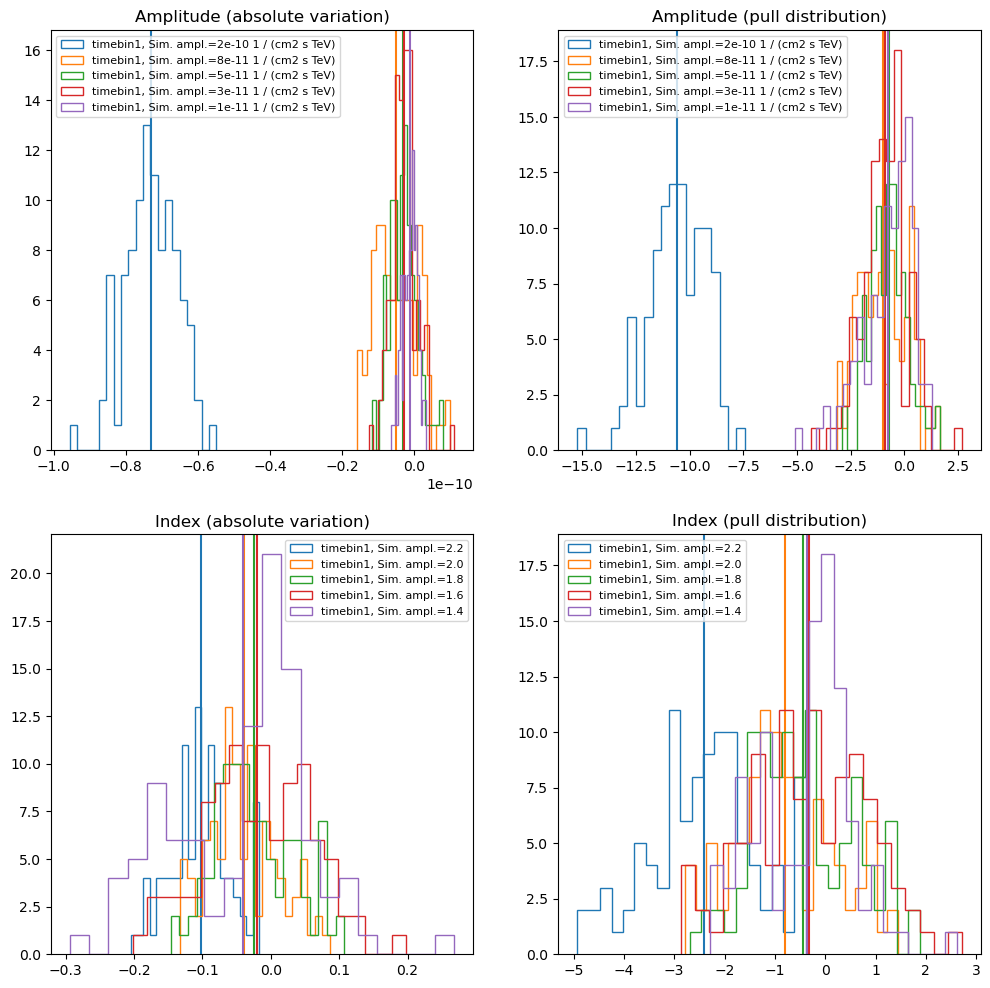

In [105]:
(amplitude_near_log, amplitude_near_log_err, index_near_log, index_near_log_err, norm_near_log_bkg, norm_near_log_bkg_err) = (amplitude, 
                                                                                                                              amplitude_err, index, 
                                                                                                                              index_err, 
                                                                                                                              norm_bkg, norm_bkg_err)
make_diagnostic_plots(ampl_model, index_model, amplitude_near_log, amplitude_near_log_err, index_near_log, index_near_log_err)

### Start the sims

Here I assume a "linear" interpolation method and "log" for the MapAxis of the RegionNDMap:

In [103]:
Nsim = 100
method = "linear"

amplitude = np.zeros((Nsim, len(time_min)))
amplitude_err = np.zeros((Nsim, len(time_min)))
index = np.zeros((Nsim, len(time_min)))
index_err = np.zeros((Nsim, len(time_min)))
norm_bkg = np.zeros((Nsim, len(time_min)))
norm_bkg_err = np.zeros((Nsim, len(time_min)))


new_time_axis = MapAxis.from_edges(edges=edges, name="time", interp="log")
nbin = 10
energy_axis_map = MapAxis.from_energy_bounds(
    energy_min=0.2 * u.TeV, energy_max=100 * u.TeV, 
    nbin=nbin, name="energy"
)
m = RegionNDMap.create(
    region=PointSkyRegion(center=position),
    axes=[energy_axis_map, new_time_axis],
)

m.data = np.array(data)
new_temporal_model = LightCurveTemplateTemporalModel(m, t_ref=t_ref, method=method)
dataset.models[0].temporal_model = new_temporal_model

for i in np.arange(Nsim):
    print(f"We are performing the simulation N#. {i}")
    sampler = MapDatasetEventSampler(random_state=i)
    events = sampler.run(dataset, observation)
    
    for j in np.arange(len(time_min)):
        print(f"We are fitting the time bin N#. {j}")
        model_fit = make_model_fit()
        dataset_fit = make_dataset_fit(j, empty, events, model_fit)
        fit = Fit()
        result = fit.run(dataset_fit)
        
        amplitude[i, j] = dataset_fit.models[0].spectral_model.parameters["amplitude"].value
        amplitude_err[i, j] = dataset_fit.models[0].spectral_model.parameters["amplitude"].error
        
        index[i, j] = dataset_fit.models[0].spectral_model.parameters["index"].value
        index_err[i, j] = dataset_fit.models[0].spectral_model.parameters["index"].error
        
        norm_bkg[i, j] = dataset_fit.models[1].spectral_model.parameters["norm"].value
        norm_bkg_err[i, j] = dataset_fit.models[1].spectral_model.parameters["norm"].error

We are performing the simulation N#. 0
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 1
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 2
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 3
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 4
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 5
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 6
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 7
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 8
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 9
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 10
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 11
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 12
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 13
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 14
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 15
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 16
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 17
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 18
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 19
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 20
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 21
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 22
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 23
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 24
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 25
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 26
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 27
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 28
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 29
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 30
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 31
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 32
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 33
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 34
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 35
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 36
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 37
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 38
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 39
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 40
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 41
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 42
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 43
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 44
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 45
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 46
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 47
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 48
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 49
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 50
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 51
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 52
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 53
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 54
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 55
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 56
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 57
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 58
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 59
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 60
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 61
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 62
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 63
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 64
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 65
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 66
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 67
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 68
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 69
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 70
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 71
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 72
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 73
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 74
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 75
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 76
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 77
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 78
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 79
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 80
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 81
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 82
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 83
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 84
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 85
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 86
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 87
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 88
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 89
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 90
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 91
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 92
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 93
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 94
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 95
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 96
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 97
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 98
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 99
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


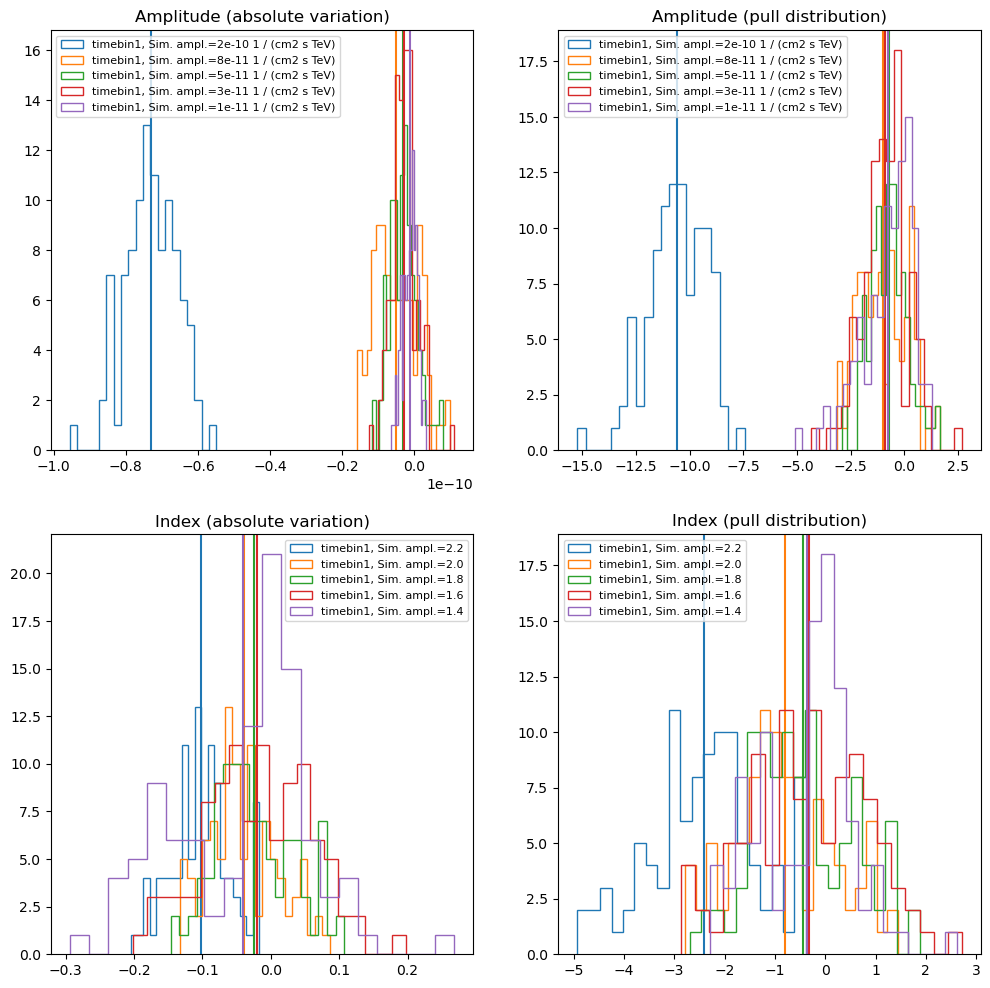

In [104]:
(amplitude_lin_log, amplitude_lin_log_err, index_lin_log, index_lin_log_err, norm_lin_log_bkg, norm_lin_log_bkg_err) = (amplitude, 
                                                                                                                              amplitude_err, index, 
                                                                                                                              index_err, 
                                                                                                                              norm_bkg, norm_bkg_err)
make_diagnostic_plots(ampl_model, index_model, amplitude_lin_log, amplitude_lin_log_err, index_lin_log, index_lin_log_err)